Next: https://github.com/arunarn2/HierarchicalAttentionNetworks/blob/master/HierarchicalAttn.py

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt
# from IPython import display

In [4]:
from sklearn.metrics import classification_report

In [5]:
import tensorflow as tf
import tensorflow_hub as hub

In [6]:
from keras import backend as K

from keras.models import Model, Input
from keras.layers.merge import add
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Bidirectional, Lambda
from keras.regularizers import l2

from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


#### Custom Functions

In [7]:
from src.callbacks import PlotCurves
from src.custom_functions import f1_score 
from src.load_data import load_data

### Load Data

In [8]:
train_data, valid_data, test_data, metadata = load_data()

#### Number of Sentences

In [9]:
print('Max number of sentences in an article:',
      max([len(article['sentences']) for article in (train_data + valid_data + test_data)]))

Max number of sentences in an article: 58


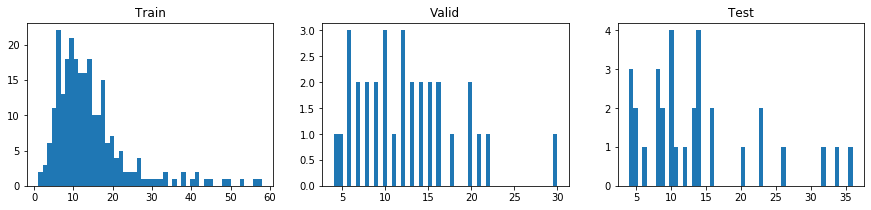

In [10]:
plt.figure(figsize=(15, 3))

plt.subplot(131)
plt.hist([len(article['sentences']) for article in train_data], bins=50)
plt.title('Train')
plt.subplot(132)
plt.hist([len(article['sentences']) for article in valid_data], bins=50)
plt.title('Valid')
plt.subplot(133)
plt.hist([len(article['sentences']) for article in test_data], bins=50)
plt.title('Test')
plt.show()

### Sequential Data 

In [23]:
max_len = 60
n_tags = 2

In [24]:
X_tra = []
for article in train_data:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(article['sentences'][i]['sentence'])
        except:
            new_seq.append("ENDPAD")
    X_tra.append(new_seq)
X_tra = np.array(X_tra)

In [25]:
X_val = []
for article in valid_data:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(article['sentences'][i]['sentence'])
        except:
            new_seq.append("ENDPAD")
    X_val.append(new_seq)
X_val = np.array(X_val)

In [26]:
X_test = []
for article in test_data:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(article['sentences'][i]['sentence'])
        except:
            new_seq.append("ENDPAD")
    X_test.append(new_seq)
X_test = np.array(X_test)

In [27]:
X_tra.shape, X_val.shape, X_test.shape

((251, 60), (32, 60), (32, 60))

In [28]:
y_tra = [[sent['label'] for sent in article['sentences']] for article in train_data]
y_tra = pad_sequences(maxlen=max_len, sequences=y_tra, padding="post", value=0)
y_tra = np.array([[to_categorical(y, num_classes=n_tags) for y in sent] for sent in y_tra])

In [29]:
y_val = [[sent['label'] for sent in article['sentences']] for article in valid_data]
y_val = pad_sequences(maxlen=max_len, sequences=y_val, padding="post", value=0)
y_val = np.array([[to_categorical(y, num_classes=n_tags) for y in sent] for sent in y_val])

In [30]:
y_test = np.array([sent['label'] for article in test_data for sent in article['sentences']])

In [31]:
y_tra.shape, y_val.shape, y_test.shape

((251, 60, 2), (32, 60, 2), (441,))

In [32]:
X_tra = X_tra[:250]
y_tra = y_tra[:250]

In [33]:
X_tra.shape, type(X_tra)

((250, 60), numpy.ndarray)

In [34]:
X_val = X_val[:32]
y_val = y_val[:32]

In [35]:
X_val.shape, y_val.shape, type(X_val)

((32, 60), (32, 60, 2), numpy.ndarray)

### Load ELMo

In [36]:
sess = tf.Session()
K.set_session(sess)

In [37]:
elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)

### Build Model

In [38]:
def ELMoEmbedding(x):
    embeds = []
    for art in tf.unstack(tf.transpose(x, (1, 0))):
        embeds.append(elmo(tf.squeeze(tf.cast(art, tf.string)), signature="default", as_dict=True)["default"])
    return tf.stack(embeds, 1)

In [39]:
def build_lstm_model():
    
    input_text = Input(shape=(max_len,), dtype="string")
    
    embedding = Lambda(ELMoEmbedding, output_shape=(None, None, max_len, 1024))(input_text)
    
    dns = Dense(512, activation='relu')(embedding)
    
    dns = Dense(256, activation='relu')(dns)
    
    x = Bidirectional(LSTM(units=128, return_sequences=True,
                           recurrent_dropout=0.2, dropout=0.2))(dns)

    x_rnn = Bidirectional(LSTM(units=128, return_sequences=True,
                               recurrent_dropout=0.2, dropout=0.2))(x)

    x = add([x, x_rnn])  # residual connection to the first biLSTM

    out = TimeDistributed(Dense(n_tags, activation="softmax"))(x)
    
    return Model(input_text, outputs=out)

In [41]:
model = build_lstm_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 60)           0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, None, None, 6 0           input_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, None, None, 6 524800      lambda_2[0][0]                   
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, None, None, 6 131328      dense_4[0][0]                    
__________________________________________________________________________________________________
bidirectio

In [42]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

W0821 17:16:19.631721 140087388590208 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/Master_Thesis/.env/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0821 17:16:19.641583 140087388590208 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/Master_Thesis/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0821 17:16:19.643342 140087388590208 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/Master_Thesis/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3378: The name tf.nn.sigmoid_cross_entropy_with_logits is deprecated. Please use tf.nn.sigmoid_cross_entropy_with_logits instead.



### Train Model

In [43]:
## Sequential Model
model.fit(X_tra, y_tra, epochs=20, batch_size=2, validation_data=(X_val, y_val)) 
#            callbacks=[PlotCurves(model_name='elmo_sentence_sequence')])

Train on 250 samples, validate on 32 samples
Epoch 1/20
250/250 [==============================] - 213s 853ms/step - loss: 0.1333 - acc: 0.9430 - val_loss: 0.0687 - val_acc: 0.9682
Epoch 2/20
250/250 [==============================] - 141s 562ms/step - loss: 0.1001 - acc: 0.9557 - val_loss: 0.0698 - val_acc: 0.9693
Epoch 3/20
250/250 [==============================] - 140s 559ms/step - loss: 0.0863 - acc: 0.9626 - val_loss: 0.0669 - val_acc: 0.9719
Epoch 4/20
250/250 [==============================] - 141s 564ms/step - loss: 0.0734 - acc: 0.9691 - val_loss: 0.0664 - val_acc: 0.9724
Epoch 5/20
250/250 [==============================] - 140s 561ms/step - loss: 0.0663 - acc: 0.9718 - val_loss: 0.0724 - val_acc: 0.9688
Epoch 6/20
250/250 [==============================] - 141s 563ms/step - loss: 0.0490 - acc: 0.9808 - val_loss: 0.0918 - val_acc: 0.9651
Epoch 7/20
250/250 [==============================] - 140s 561ms/step - loss: 0.0353 - acc: 0.9865 - val_loss: 0.0976 - val_acc: 0.9687
Epo

### Test

In [48]:
model_preds = model.predict(X_test, batch_size=2)

In [49]:
y_preds = [[np.argmax(lab) for lab in art] for art in model_preds]

In [50]:
y_preds_unpad = []
for ai, art in enumerate(X_test):
    for si, sent in enumerate(art):
        if sent != 'ENDPAD':
            y_preds_unpad.append(y_preds[ai][si])

In [51]:
### Sequential Model results
print(classification_report(y_test, y_preds_unpad))

              precision    recall  f1-score   support

           0       0.90      0.78      0.84       325
           1       0.55      0.75      0.64       116

   micro avg       0.77      0.77      0.77       441
   macro avg       0.72      0.77      0.74       441
weighted avg       0.81      0.77      0.78       441

